In [ ]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl

In [ ]:
!pip install torchvision

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
#from torchvision.transforms import Compose, ToPILImage, ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision
import numpy as np
import h5py
from matplotlib import pyplot as plt
plt.ion()   # interactive mode

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
# downloading file
!wget https://www.dropbox.com/s/fo12doky65vhvet/X_4mm.h5?dl=1 -O X_4mm.h5

In [2]:
def load_large_dataset(file_name):
    h5f = h5py.File(file_name + '.h5','r')
    variable = h5f['variable'][:]
    h5f.close()
    return variable

In [3]:
X = load_large_dataset('X_4mm')

In [4]:
LATENT_DIM = 5 #size of the latent space in the variational autoencoder
BATCH_SIZE = 128
NUMBER_OF_IMAGES = len(X)

In [5]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        # layers for encoder
        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(32*5*6*5, LATENT_DIM)
        self.fc2 = nn.Linear(32*5*6*5, LATENT_DIM)
        
        # layers for decoder
        self.fc_decoder = nn.Linear(LATENT_DIM, 32*5*6*5)
        
        self.conv1_decoder = nn.Conv3d(32, 32, kernel_size=3, padding=1) 
        self.conv2_decoder = nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.conv3_decoder = nn.Conv3d(32, 32, kernel_size=3, padding=1)
        
        self.conv4_decoder = nn.Conv3d(32, 1, kernel_size=3, padding=3)
        
        
    def encode(self, x):
        x = F.relu(self.conv1(x)) #shape after conv: (8, 44, 53, 44)
        x = F.max_pool3d(x, kernel_size=2) #shape after pooling: (8, 22, 26, 22)

        x = F.relu(self.conv2(x)) #shape after conv: (16, 22, 26, 22)
        x = F.max_pool3d(x, kernel_size=2) #shape after pooling: (16, 11, 13, 11)
        
        x = F.relu(self.conv3(x)) #shape after conv: (32, 11, 13, 11)
        x = F.max_pool3d(x, kernel_size=2) #shape after pooling: (32, 5, 6, 5)

        x = x.view(-1, 5*6*5*32)
        return self.fc1(x), self.fc2(x)
    
    
    def reparameterize(self, mu, logvar):

        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    
    def decode(self, z):
        z = F.relu(self.fc_decoder(z))
        z = z.view(-1, 32,5,6,5) #reshape to (32, 5, 6, 5)
        
        z = F.relu(self.conv1_decoder(z)) #shape after conv (32, 5, 6, 5)
        z = F.upsample(z, scale_factor=2, mode='nearest') #shape after upsampling (32, 10, 12, 10)
        z = F.relu(self.conv2_decoder(z)) #shape after conv (32, 10, 12, 10)
        z = F.upsample(z, scale_factor=2, mode='nearest') #shape after upsampling (32, 20, 24, 20)
        z = F.relu(self.conv3_decoder(z)) #shape after conv (32,16,16)
        z = F.upsample(z, scale_factor=2, mode='nearest') #shape after conv (32, 40, 48, 40)
        z = self.conv4_decoder(z) #shape after conv (1, 44, 52, 44)
        z = F.pad(z, (0,0,0,1,0,0), "constant", -10) #after padding (1, 44, 53, 44) (to match the input size)
        return F.sigmoid(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar    

In [6]:
def loss_function(reconstruced_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstruced_x.view(-1, 44*53*44), x.view(-1, 44*53*44), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [7]:
images = torch.from_numpy(X) #convert to torch tensor
images = images.view(NUMBER_OF_IMAGES, 1, 44, 53, 44) #reshape

In [8]:
train_set = torch.utils.data.TensorDataset(images, torch.zeros(NUMBER_OF_IMAGES))
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

In [9]:
net = VAE()
optimizer = optim.Adam(net.parameters())
net.cuda()

VAE(
  (conv1): Conv3d (1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d (8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d (16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=4800, out_features=5)
  (fc2): Linear(in_features=4800, out_features=5)
  (fc_decoder): Linear(in_features=5, out_features=4800)
  (conv1_decoder): Conv3d (32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2_decoder): Conv3d (32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3_decoder): Conv3d (32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4_decoder): Conv3d (32, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 3, 3))
)

In [10]:
reconstructed_images = torch.zeros(16,1,44,53)
reconstructed_images_2 = torch.zeros(16,1,44,53)

In [ ]:
for epoch in range(151):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        reconstructed_batch, mu, logvar = net(inputs)
        
        outputs = net(inputs)
        loss = loss_function(reconstructed_batch, inputs, mu, logvar)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]*inputs.size(0)

    print('Epoch %d, loss: %.3f' % (epoch + 1, running_loss / NUMBER_OF_IMAGES))
    
    if (epoch%10==0): #saving examples of reconstructed images every 10 epochs
      output = net(Variable(train_loader.dataset[0][0].unsqueeze(0).cuda()))
      output = output[0].data.view(1,44,53,44).cpu()
      reconstructed_images[int(epoch/10)] = output[0,:,:,28] #slice number 28
      reconstructed_images_2[int(epoch/10)] = output[0,:,:,10] #slice number 10
    
    
print('Finished Training')

Epoch 1, loss: 6255062.938
Epoch 2, loss: 3789412.725
Epoch 3, loss: 3627087.872
Epoch 4, loss: 3571872.159
Epoch 5, loss: 3546807.372
Epoch 6, loss: 3532047.797
Epoch 7, loss: 3513694.605
Epoch 8, loss: 3494107.048
Epoch 9, loss: 3480153.034
Epoch 10, loss: 3467739.820
Epoch 11, loss: 3456572.482
Epoch 12, loss: 3442928.012
Epoch 13, loss: 3432728.738
Epoch 14, loss: 3421185.347
Epoch 15, loss: 3453663.818
Epoch 16, loss: 3412676.471
Epoch 17, loss: 3395376.723
Epoch 18, loss: 3382849.076
Epoch 19, loss: 3371738.834
Epoch 20, loss: 3353009.223
Epoch 21, loss: 3302558.716
Epoch 23, loss: 3277186.309
Epoch 24, loss: 3236284.390
Epoch 25, loss: 3210899.798
Epoch 26, loss: 3194574.375
Epoch 27, loss: 3191211.208
Epoch 28, loss: 3179589.155
Epoch 29, loss: 3157535.682
Epoch 30, loss: 3145463.943
Epoch 31, loss: 3143611.244
Epoch 32, loss: 3124265.241
Epoch 33, loss: 3113204.571
Epoch 34, loss: 3107534.066
Epoch 35, loss: 3093286.302
Epoch 36, loss: 3084037.092
Epoch 37, loss: 3075999.073
E

Let's see how the quality of reconstructed images improve over training time. The original image looks like this:

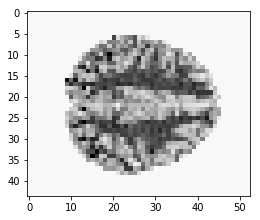

In [12]:
fig = plt.figure(figsize=(4,4))
my_slice = images[0,0,:,:,28]
plt.imshow(my_slice, cmap="Greys")

and below we show reconstructions of the above slice every 10 epochs

In [13]:
grid_1 = torchvision.utils.make_grid(reconstructed_images, nrow=5)
grid_2 = torchvision.utils.make_grid(reconstructed_images_2, nrow=5)
grid_1 = grid_1[0,:,:]
grid_2 = grid_2[0,:,:]

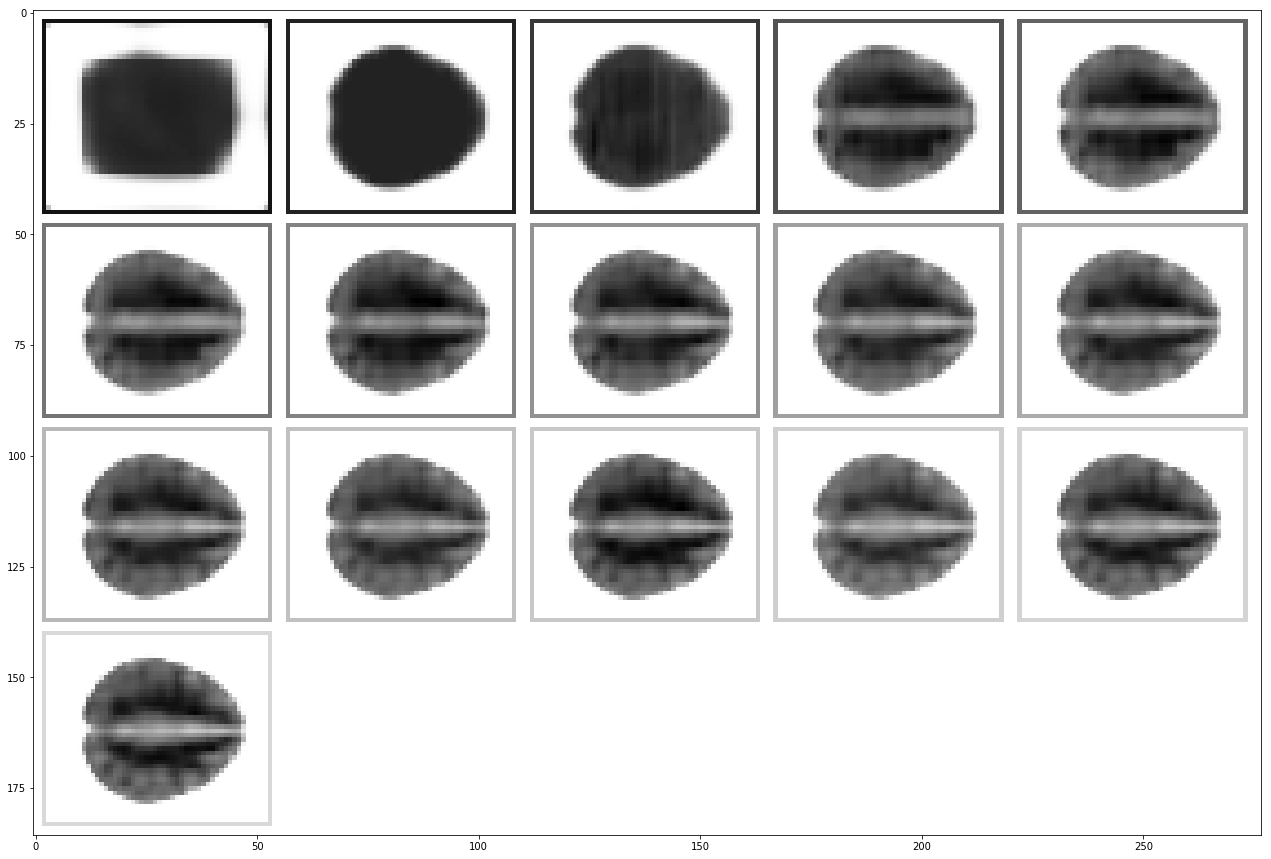

In [14]:
plt.rcParams['grid.linewidth'] = 0.0
fig = plt.figure(figsize=(22,22))
plt.imshow(grid_1, cmap="Greys")

Let's check another slice

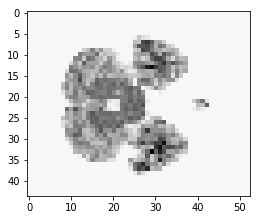

In [15]:
fig = plt.figure(figsize=(4,4))
my_slice = images[0,0,:,:,10]
plt.imshow(my_slice, cmap="Greys")

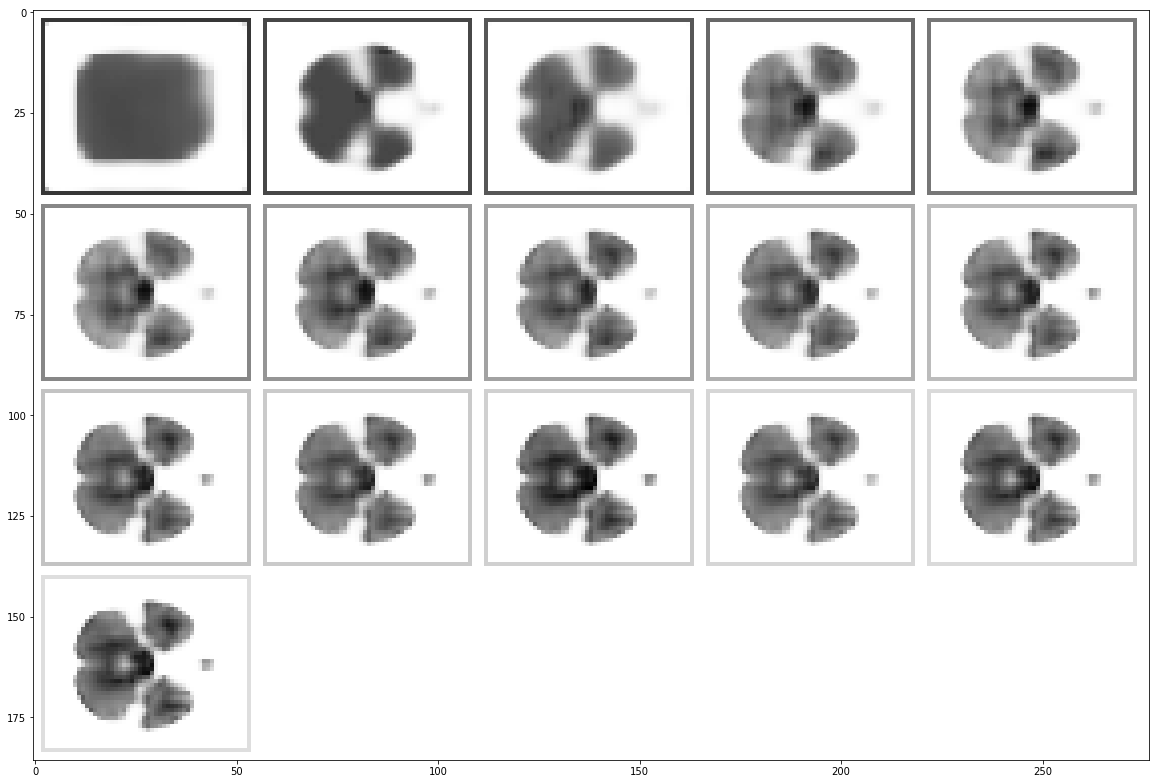

In [16]:
fig = plt.figure(figsize=(20,20))
plt.imshow(grid_2, cmap="Greys")

After 70-80 basically the reconstructed images look the same. However, the loss function still goes down (presumably latent space is getting better 'organized')